In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os
pd.set_option('display.max_rows', 100)

# Load Data

In [8]:
turnstile_list = ['190504','190511','190518','190525']

turnstile_path = 'turnstile_data/'

if not os.path.isdir(turnstile_path):
    turnstile_path = "http://web.mta.info/developers/data/nyct/turnstile/"

def read_data(turnstile_list):
    """
    Reading turnstile data and making a data frame
    """
    df_list = []
    for f in turnstile_list:
        df_ = pd.read_csv(turnstile_path + 'turnstile_{}.txt'.format(f))
        df_list.append(df_)
        
    return pd.concat(df_list).reset_index(drop=True)

df=read_data(turnstile_list)
df.shape

(822989, 11)

In [78]:
# Removing the white spaces from columns in data set
for col in df.columns:
    df = df.rename(columns={col: col.rstrip()})

(822989, 11)

# Date and Time columns

In [4]:
#Creates DATETIME,HOUR,WEEK OF YEAR,DAY OF WEEK,WEEKEND
# Convert strings to datetimes
df=df[df['TIME'].str.contains('00:00')]
df['DATETIME']=df['DATE']+' '+df['TIME']
df['DATETIME']=pd.to_datetime(df['DATETIME'])
df['DATE']=pd.to_datetime(df['DATE'])
df['TIME']=pd.to_datetime(df['TIME'],format= '%H:%M:%S' ).dt.time
df['HOUR']=pd.to_datetime(df['TIME'],format= '%H:%M:%S' ).dt.hour
df['WEEK OF YEAR']=df['DATETIME'].dt.weekofyear
df['DAY OF WEEK']=df['DATETIME'].dt.dayofweek.astype('int')
df['WEEKEND']=(df['DAY OF WEEK']==5)|(df['DAY OF WEEK']==6)

# Sort char in line names

In [5]:
def char_sort(word): 
    """
    sorts the chars in a string
    """
    char_list = [char for char in str(word)]
    sorted_word = "".join(sorted(char_list))
    return sorted_word

df['LINENAME'] = df['LINENAME'].apply(char_sort)

In [6]:
df['STATION LINE'] = df['STATION'] + "-" + df['LINENAME']

# Daily dateframe

In [7]:
df_daily=df.copy()

df_daily=df_daily.groupby(["C/A", "UNIT", "SCP", "DATE", 'STATION LINE'],as_index=False).first()
df_daily.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION LINE","DATE"], inplace=True)
df_daily['NET ENTRIES']=abs(df_daily.groupby(['C/A','UNIT','SCP','STATION LINE'])['ENTRIES'].diff(-1)*-1)
df_daily['NET EXITS']=abs(df_daily.groupby(["C/A", "UNIT", "SCP", 'STATION LINE'])['EXITS'].diff(-1)*-1)
df_daily['DAYS DIFF']=df_daily.groupby(["C/A", "UNIT", "SCP", "STATION LINE"])['DATE'].diff(-1)*-1
df_daily=df_daily[df_daily['NET ENTRIES']<50000]
df_daily['DAYS DIFF'].value_counts()
df_daily['DAYS DIFF']=df_daily['DAYS DIFF'].dt.days
df_daily['NET ENTRIES']=df_daily['NET ENTRIES']//df_daily['DAYS DIFF']
df_daily['NET EXITS']=df_daily['NET EXITS']//df_daily['DAYS DIFF']
df_daily['NET MOVEMENT']=df_daily['NET ENTRIES']+df_daily['NET EXITS']
df_daily.dropna(inplace=True)

#Optimization- deal with resetting counters in a better way

In [8]:
df_daily['NET ENTRIES'].sort_values()

124462        0.0
74542         0.0
74541         0.0
74540         0.0
74539         0.0
           ...   
92154     26076.0
26689     28517.0
10194     34006.0
26675     38364.0
16602     43080.0
Name: NET ENTRIES, Length: 119899, dtype: float64

In [9]:
#corrected for outliers
total_df=df_daily.groupby(['STATION LINE','DATE'])['NET MOVEMENT'].sum().reset_index()
total_df=total_df.groupby('STATION LINE')['NET MOVEMENT'].mean().sort_values(ascending=False).reset_index()
total_df['NET MOVEMENT']=total_df['NET MOVEMENT'].astype('int')

top_10_daily=total_df.head(10)
print(top_10_daily)
top_stations=list(top_10_daily['STATION LINE'])

                   STATION LINE  NET MOVEMENT
0         GRD CNTRL-42 ST-4567S        247351
1      34 ST-HERALD SQ-BDFMNQRW        211748
2       14 ST-UNION SQ-456LNQRW        180388
3   TIMES SQ-42 ST-1237ACENQRSW        153354
4            FULTON ST-2345ACJZ        144942
5  42 ST-PORT AUTH-1237ACENQRSW        144096
6            34 ST-PENN STA-ACE        140765
7          59 ST COLUMBUS-1ABCD        121456
8           47-50 STS ROCK-BDFM        104505
9                 59 ST-456NQRW         93785


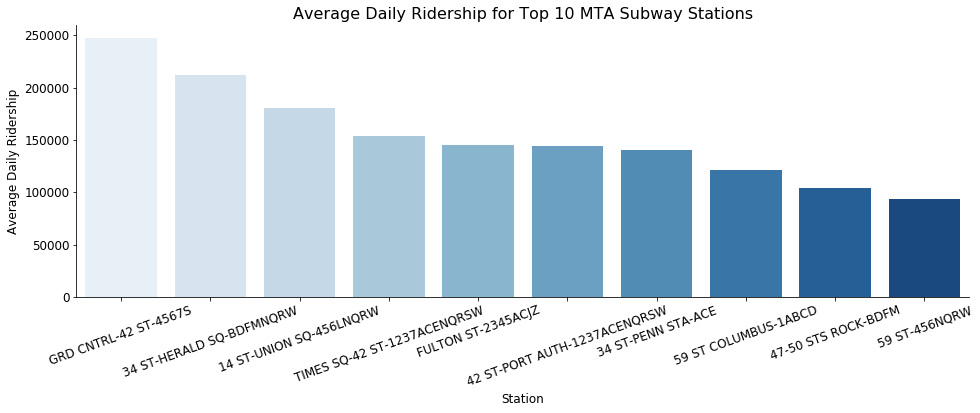

In [10]:
plt.figure(figsize=[16,5])
font={'size':12}
plt.rc('font', **font) 
sns.barplot(x ='STATION LINE',y='NET MOVEMENT',data=top_10_daily,palette=sns.color_palette("Blues",10));
plt.xticks(rotation=20);
plt.xlabel('Station')
plt.ylabel('Average Daily Ridership')
plt.title('Average Daily Ridership for Top 10 MTA Subway Stations',size=16)
sns.despine()
plt.savefig("Average_daily_ridership.png",bbox_inches='tight')

# Hourly dateframe

In [11]:
df_hourly=df.copy()

df_hourly.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION LINE","DATE","TIME"], inplace=True)
df_hourly['NET ENTRIES']=abs(df_hourly.groupby(['C/A','UNIT','SCP','STATION LINE'])['ENTRIES'].diff(-1)*-1)
df_hourly['NET EXITS']=abs(df_hourly.groupby(["C/A", "UNIT", "SCP", "STATION LINE"])['EXITS'].diff(-1)*-1)
df_hourly=df_hourly[df_hourly['NET ENTRIES']<50000]
df_hourly['HOURS DIFF']=df_hourly.groupby(["C/A", "UNIT", "SCP", "STATION LINE"])['HOUR'].diff(-1)*-1
df_hourly['HOURS DIFF'] = df_hourly['HOURS DIFF'].replace(to_replace=-20.0, value=4.0)
df_hourly = df_hourly[df_hourly['HOURS DIFF']==4.0]
df_hourly['NET ENTRIES']=df_hourly['NET ENTRIES']//df_hourly['HOURS DIFF']
df_hourly['NET EXITS']=df_hourly['NET EXITS']//df_hourly['HOURS DIFF']
df_hourly['NET MOVEMENT']=df_hourly['NET ENTRIES']+df_hourly['NET EXITS']

df_hourly.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,DATETIME,HOUR,WEEK OF YEAR,DAY OF WEEK,WEEKEND,STATION LINE,NET ENTRIES,NET EXITS,HOURS DIFF,NET MOVEMENT
0,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,00:00:00,REGULAR,7035249,...,2019-04-27 00:00:00,0,17,5,True,59 ST-456NQRW,5.0,1.0,4.0,6.0
1,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,04:00:00,REGULAR,7035269,...,2019-04-27 04:00:00,4,17,5,True,59 ST-456NQRW,5.0,8.0,4.0,13.0
2,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,08:00:00,REGULAR,7035292,...,2019-04-27 08:00:00,8,17,5,True,59 ST-456NQRW,25.0,19.0,4.0,44.0
3,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,12:00:00,REGULAR,7035392,...,2019-04-27 12:00:00,12,17,5,True,59 ST-456NQRW,64.0,17.0,4.0,81.0
4,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,16:00:00,REGULAR,7035651,...,2019-04-27 16:00:00,16,17,5,True,59 ST-456NQRW,69.0,12.0,4.0,81.0


In [12]:
df_hourly['HOURS DIFF'] = df_hourly['HOURS DIFF'].replace(to_replace=-20.0, value=4.0)
df_hourly = df_hourly[df_hourly['HOURS DIFF']==4.0]

In [13]:
# shifting hours to match 0,4,8,12,16,20 schedule
df_hourly['HOUR'].value_counts()
df_hourly['HOUR'] = df_hourly['HOUR'].replace(to_replace={1:0, 5:4, 9:8, 13:12, 17:16, 21:20})
df_hourly = df_hourly[df_hourly['HOUR'].isin([0.0,4.0,8.0,12.0,16.0,20.0])]
station_hourly_df=df_hourly.groupby(['STATION LINE','DATE', 'HOUR'])['NET MOVEMENT'].sum().reset_index()
station_hourly_df=station_hourly_df.groupby(['STATION LINE','HOUR'])['NET MOVEMENT'].mean().sort_values(ascending=False).reset_index()
station_hourly_df.head()

,STATION LINE,HOUR,NET MOVEMENT
0,GRD CNTRL-42 ST-4567S,16,19860.000000
1,34 ST-HERALD SQ-BDFMNQRW,16,18091.296296
2,GRD CNTRL-42 ST-4567S,8,14959.214286
3,14 ST-UNION SQ-456LNQRW,16,13319.222222
4,GRD CNTRL-42 ST-4567S,12,13097.000000


In [14]:
# station_hourly_df=dfhourly.groupby(['STATION','DATE', 'HOUR'])['NET ENTRIES'].sum().reset_index()
# station_hourly_df.head(10)
#dfhourly[(dfhourly['STATION']=='1 AV')& (dfhourly['DATE']=='2019-04-27')]
df_hourly['HOURS DIFF'].value_counts()

4.0    709535
Name: HOURS DIFF, dtype: int64

In [15]:
station_hourly_df[station_hourly_df['STATION LINE'].isin(top_stations)]['STATION LINE'].value_counts()

34 ST-PENN STA-ACE              6
34 ST-HERALD SQ-BDFMNQRW        6
59 ST COLUMBUS-1ABCD            6
GRD CNTRL-42 ST-4567S           6
42 ST-PORT AUTH-1237ACENQRSW    6
59 ST-456NQRW                   6
TIMES SQ-42 ST-1237ACENQRSW     6
47-50 STS ROCK-BDFM             6
FULTON ST-2345ACJZ              6
14 ST-UNION SQ-456LNQRW         6
Name: STATION LINE, dtype: int64

In [17]:
top_station_hourly = station_hourly_df[station_hourly_df['STATION LINE'].isin(top_stations)]
total_sum = top_station_hourly.groupby(['STATION LINE'])['NET MOVEMENT'].sum()
top_station_hourly = top_station_hourly.merge(total_sum, left_on='STATION LINE', right_on='STATION LINE')
top_station_hourly.head()
top_station_hourly['RELATIVE NET MOVEMENT'] = top_station_hourly['NET MOVEMENT_x'] / top_station_hourly['NET MOVEMENT_y']
top_station_hourly.head()

,STATION LINE,HOUR,NET MOVEMENT_x,NET MOVEMENT_y,RELATIVE NET MOVEMENT
0,GRD CNTRL-42 ST-4567S,16,19860.000000,61953.47619,0.320563
1,GRD CNTRL-42 ST-4567S,8,14959.214286,61953.47619,0.241459
2,GRD CNTRL-42 ST-4567S,12,13097.000000,61953.47619,0.211401
3,GRD CNTRL-42 ST-4567S,4,8778.928571,61953.47619,0.141702
4,GRD CNTRL-42 ST-4567S,20,4718.333333,61953.47619,0.076159


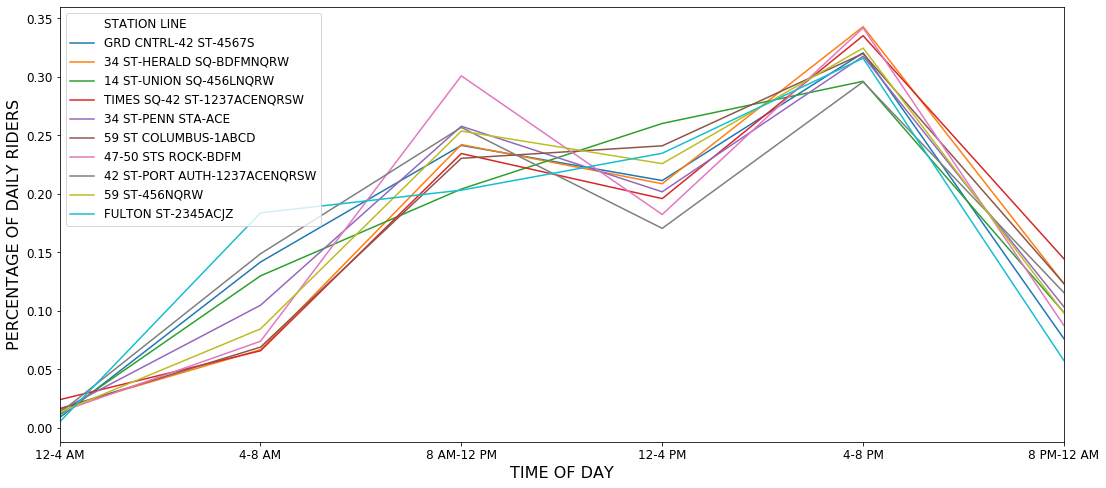

In [18]:
plt.figure(figsize=(18,8))
font = {'size':12}
plt.rc('font', **font) 
plt.xticks([0.0,4.0,8.0,12.0,16.0,20.0],['12-4 AM', '4-8 AM', '8 AM-12 PM', '12-4 PM', '4-8 PM', '8 PM-12 AM'])
# plt.xticks(['12-4 AM', '4-8 AM', '8 AM-12 PM', '12-4 PM', '4-8 PM', '8 PM-12 AM'])

sns.lineplot(data=top_station_hourly, x='HOUR', y='RELATIVE NET MOVEMENT', hue='STATION LINE', markers=True)
plt.xlim(0,20)
plt.legend(loc=2)
plt.xlabel('TIME OF DAY', size=16)
plt.ylabel('PERCENTAGE OF DAILY RIDERS', size=16)
plt.savefig("Time_of_day3.png")

In [19]:
df_hourly.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,DATETIME,HOUR,WEEK OF YEAR,DAY OF WEEK,WEEKEND,STATION LINE,NET ENTRIES,NET EXITS,HOURS DIFF,NET MOVEMENT
0,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,00:00:00,REGULAR,7035249,...,2019-04-27 00:00:00,0,17,5,True,59 ST-456NQRW,5.0,1.0,4.0,6.0
1,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,04:00:00,REGULAR,7035269,...,2019-04-27 04:00:00,4,17,5,True,59 ST-456NQRW,5.0,8.0,4.0,13.0
2,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,08:00:00,REGULAR,7035292,...,2019-04-27 08:00:00,8,17,5,True,59 ST-456NQRW,25.0,19.0,4.0,44.0
3,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,12:00:00,REGULAR,7035392,...,2019-04-27 12:00:00,12,17,5,True,59 ST-456NQRW,64.0,17.0,4.0,81.0
4,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,16:00:00,REGULAR,7035651,...,2019-04-27 16:00:00,16,17,5,True,59 ST-456NQRW,69.0,12.0,4.0,81.0


In [21]:
df_hourly_top=df_hourly[df_hourly['STATION LINE'].isin(top_stations)]
top_counts=df_hourly_top['TIME'].value_counts()
top_counts=top_counts[top_counts>100]
print(top_counts)

12:00:00    9408
00:00:00    9390
08:00:00    9385
04:00:00    9370
16:00:00    9067
20:00:00    9064
05:00:00    3409
13:00:00    3404
09:00:00    3402
01:00:00    3395
17:00:00    3289
21:00:00    3274
Name: TIME, dtype: int64


# Average Weekend vs Weekday Ridership

In [22]:
weekend_df = df_daily[df_daily["WEEKEND"]]
week_df = df_daily[df_daily["WEEKEND"] == False]

## Weekend

In [23]:
total_df_weekend=weekend_df.groupby(['STATION LINE','DATE'])['NET MOVEMENT'].sum().reset_index()
total_df_weekend=total_df_weekend.groupby('STATION LINE')['NET MOVEMENT'].mean().sort_values(ascending=False).reset_index()
total_df_weekend['NET MOVEMENT']=total_df_weekend['NET MOVEMENT'].astype('int')
total_df_weekend["TIME"]='Weekend Average'
top_10_weekend=total_df_weekend.head(10)
print(top_10_weekend)
top_stations=list(top_10_weekend['STATION LINE'])

                   STATION LINE  NET MOVEMENT             TIME
0      34 ST-HERALD SQ-BDFMNQRW        129592  Weekend Average
1       14 ST-UNION SQ-456LNQRW        119292  Weekend Average
2         GRD CNTRL-42 ST-4567S        104941  Weekend Average
3   TIMES SQ-42 ST-1237ACENQRSW         97798  Weekend Average
4  42 ST-PORT AUTH-1237ACENQRSW         96749  Weekend Average
5            34 ST-PENN STA-ACE         84103  Weekend Average
6          59 ST COLUMBUS-1ABCD         76993  Weekend Average
7        W 4 ST-WASH SQ-ABCDEFM         61452  Weekend Average
8            FULTON ST-2345ACJZ         59399  Weekend Average
9         JKSN HT-ROOSVLT-7EFMR         58919  Weekend Average


## Weekday

In [24]:
total_df_week=week_df.groupby(['STATION LINE','DATE'])['NET MOVEMENT'].sum().reset_index()
total_df_week=total_df_week.groupby('STATION LINE')['NET MOVEMENT'].mean().sort_values(ascending=False).reset_index()
total_df_week['NET MOVEMENT']=total_df_week['NET MOVEMENT'].astype('int')
total_df_week["TIME"]='Weekday Average'
top_10_week=total_df_week.head(10)
print(top_10_week)
top_stations_week=list(top_10_week['STATION LINE'])

                   STATION LINE  NET MOVEMENT             TIME
0         GRD CNTRL-42 ST-4567S        307313  Weekday Average
1      34 ST-HERALD SQ-BDFMNQRW        246340  Weekday Average
2       14 ST-UNION SQ-456LNQRW        206113  Weekday Average
3            FULTON ST-2345ACJZ        180960  Weekday Average
4   TIMES SQ-42 ST-1237ACENQRSW        176747  Weekday Average
5            34 ST-PENN STA-ACE        164623  Weekday Average
6  42 ST-PORT AUTH-1237ACENQRSW        164032  Weekday Average
7          59 ST COLUMBUS-1ABCD        140177  Weekday Average
8           47-50 STS ROCK-BDFM        132020  Weekday Average
9                 59 ST-456NQRW        112011  Weekday Average


## Weekend Weekday Delta

                     DAILY  WEEKEND  WEEKDAY  WEEKEND DELTA  abs WEEKEND DELTA
JAY ST-METROTEC-ACF  53628  24583.0    65857       0.769635           0.769635
JAY ST-METROTEC-R     6115   2971.0     7439       0.730662           0.730662
                    DAILY  WEEKEND  WEEKDAY  WEEKEND DELTA  abs WEEKEND DELTA
GRAND ARMY PLAZ-23   9511   6716.0    10688       0.417622           0.417622


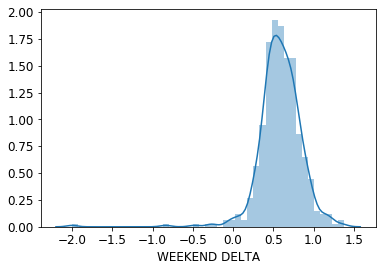

In [25]:
weekend_delta = total_df.copy()
weekend_delta = weekend_delta.set_index('STATION LINE')
weekend_delta = pd.concat([weekend_delta,
                  total_df_weekend.set_index('STATION LINE')['NET MOVEMENT'],
                  total_df_week.set_index('STATION LINE')['NET MOVEMENT']],
                 axis=1)
weekend_delta.columns=['DAILY', 'WEEKEND','WEEKDAY']
weekend_delta['WEEKEND DELTA'] = (weekend_delta['WEEKDAY'] - weekend_delta['WEEKEND'])/weekend_delta['DAILY']
weekend_delta['abs WEEKEND DELTA'] = np.abs(weekend_delta['WEEKEND DELTA'])
weekend_delta = weekend_delta.sort_values('abs WEEKEND DELTA', ascending = False)

order = weekend_delta[weekend_delta.index.isin(top_10_daily['STATION LINE'])].index#.str.title()

sns.distplot(weekend_delta['WEEKEND DELTA'])
weekend_delta[weekend_delta['DAILY']>10000].tail(20)
print(weekend_delta[weekend_delta.index.str.contains("JAY")])
print(weekend_delta[weekend_delta.index.str.contains("ARMY")])

## Plot

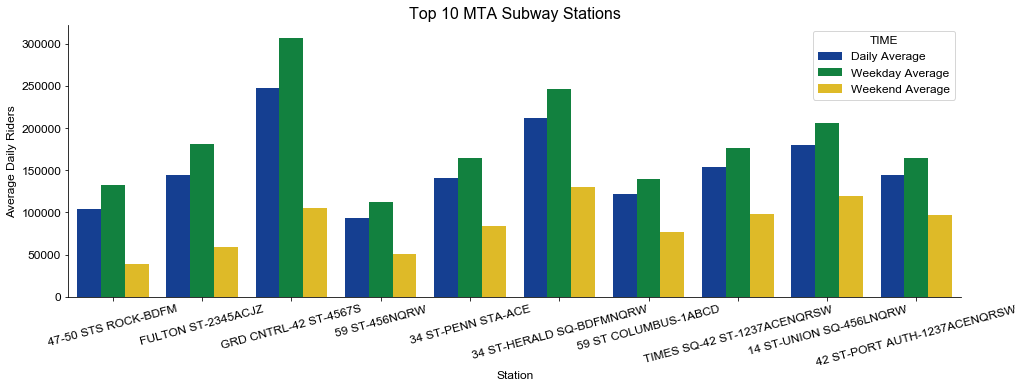

In [26]:
data = total_df.copy()
data["TIME"]='Daily Average'
data = pd.concat([data,total_df_week,total_df_weekend])
data = data[data['STATION LINE'].isin(top_10_daily['STATION LINE'])]
data['STATION LINE'] = data['STATION LINE']#.str.title()
plt.figure(figsize=[16,5])
font={'size':12}
plt.rc('font', **font) 
sns.barplot(x ='STATION LINE',y='NET MOVEMENT',hue = 'TIME',data=data,palette=sns.color_palette(["#0039A6","#00933C","#FCCC0A"]),order=order); #,palette=sns.color_palette("Blues",4)
sns.set_style("whitegrid")

plt.xticks(rotation=15);
plt.xlabel('Station')
plt.ylabel('Average Daily Riders')
plt.title('Top 10 MTA Subway Stations',size=16)
sns.despine()
plt.savefig("Top 10 MTA Subway Stations.png",bbox_inches='tight')

# Demographics

In [27]:
# 23rd, 28th, Canal are hot spots for density of startups and volume of daily traffic- 23 ST-NRW, 23 ST-FM, CANAL ST-6JNQRWZ, 28 ST-6,28 ST-NRW
# 59th/59th and Columbus has a high density of women- 59 ST COLUMBUS-1ABCD, 59 ST-456NQRW
# Herald Square has a higher density of women- 34 ST-HERALD SQ-BDFMNQRW
# NYU: 6th, Washington Sq W 4 ST-WASH SQ-ABCDEFM
# Barnard and Columbia: W 116th St (#34)- 116 ST-COLUMBIA-1
# CUNY Baruch: E 29th- 23 ST-6

women_station_lines=['59 ST COLUMBUS-1ABCD','59 ST-456NQRW','34 ST-HERALD SQ-BDFMNQRW']
university_station_lines=['23 ST-6','116 ST-COLUMBIA-1','W 4 ST-WASH SQ-ABCDEFM']
tech_station_lines=['23 ST-NRW','23 ST-FM','CANAL ST-6JNQRWZ','28 ST-6','28 ST-NRW']
demographic_station_lines=women_station_lines+university_station_lines+tech_station_lines
demographic_df=total_df[total_df['STATION LINE'].isin(demographic_station_lines)]
demographic_df['DEMOGRAPHIC CATEGORY']=demographic_df['STATION LINE']
demographic_df.loc[demographic_df['STATION LINE'].isin(women_station_lines),'DEMOGRAPHIC CATEGORY']='HIGHER DENSITY OF WOMEN'
demographic_df.loc[demographic_df['STATION LINE'].isin(university_station_lines),'DEMOGRAPHIC CATEGORY']='TARGET UNIVERSITY AREA'
demographic_df.loc[demographic_df['STATION LINE'].isin(tech_station_lines),'DEMOGRAPHIC CATEGORY']='TECH HUB'

C:\Users\bubbl\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\bubbl\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


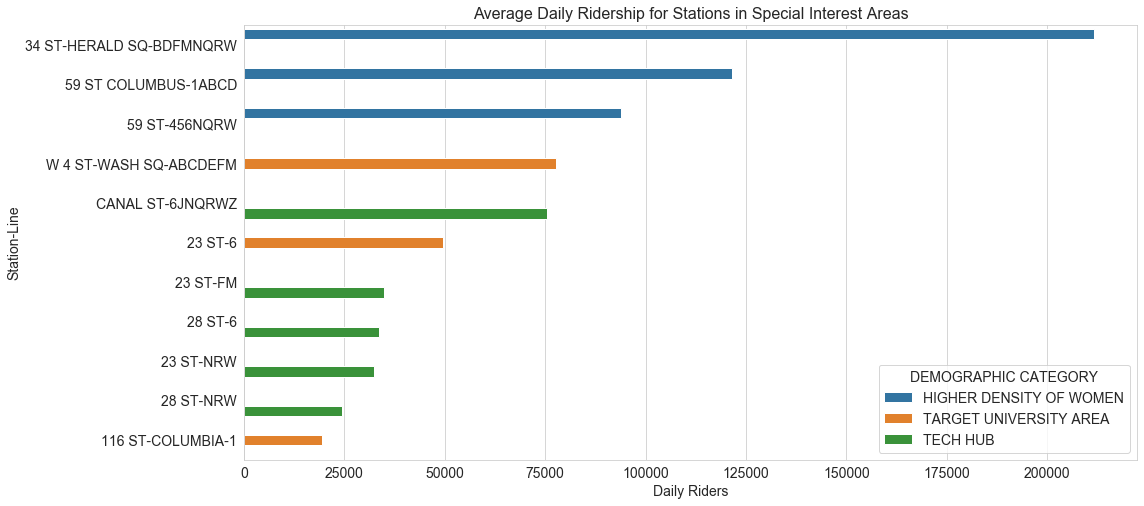

In [28]:
plt.figure(figsize=(16,8))
font = {'size':14}
plt.rc('font', **font) 
sns.barplot(x='NET MOVEMENT',y='STATION LINE',data=demographic_df,hue='DEMOGRAPHIC CATEGORY',orient='h')
plt.xlabel('Daily Riders')
plt.ylabel('Station-Line')
plt.title('Average Daily Ridership for Stations in Special Interest Areas',size=16)
plt.savefig("Demographics.png", bbox_inches='tight')